In [1]:
import torch 
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to tensor and scales [0,255] -> [0,1]
])
trainset = datasets.MNIST(root='./data/', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data/', train=False, download=True, transform=transform)


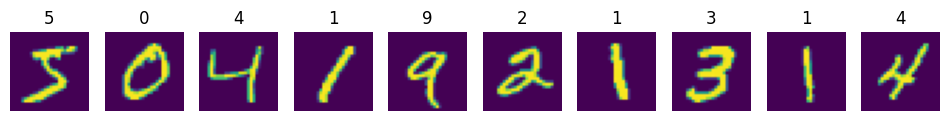

In [3]:
plt.figure(figsize=(12, 2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(trainset[i][0].squeeze())
    plt.title(trainset[i][1])
    plt.axis('off')

In [4]:
train_loader = DataLoader(dataset=trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=testset, batch_size=64, shuffle=False)


In [5]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Min pixel value: {images.min().item()}")  # Should be 0.0
print(f"Max pixel value: {images.max().item()}")  # Should be 1.0

Min pixel value: 0.0
Max pixel value: 1.0


In [23]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# ✅ Step 1: Define Function to Generate Positive & Negative Pairs
def generate_pairs(X, y):
    X_pairs = []
    y_pairs = []

    for i in range(len(X)):
        digit = y[i]

        # Find a positive pair (same class)
        positive_digit_index = np.random.choice(np.where(y == digit)[0])
        X_pairs.append([X[i], X[positive_digit_index]])
        y_pairs.append([0])  # Label 0 for positive pairs

        # Find a negative pair (different class)
        negative_digit_index = np.random.choice(np.where(y != digit)[0])
        X_pairs.append([X[i], X[negative_digit_index]])
        y_pairs.append([1])  # Label 1 for negative pairs

    # Shuffle pairs
    indices = np.arange(len(X_pairs))
    np.random.shuffle(indices)

    return np.array(X_pairs)[indices], np.array(y_pairs)[indices]

# ✅ Step 2: Custom PyTorch Dataset for Pairwise Data
class PairDataset(Dataset):
    def __init__(self, train=True):
        # Load MNIST dataset
        transform = transforms.Compose([transforms.ToTensor()])
        dataset = datasets.MNIST(root="./data", train=train, download=True, transform=transform)

        # Extract images and labels as NumPy arrays
        X = np.array([img.numpy() for img, _ in dataset])
        y = np.array([label for _, label in dataset])

        self.X_pairs, self.y_pairs = generate_pairs(X, y)

        self.X_pairs = torch.tensor(self.X_pairs, dtype=torch.float32)  # Shape: (num_samples, 2, 1, 28, 28)
        self.y_pairs = torch.tensor(self.y_pairs, dtype=torch.float32)  # Labels: (num_samples, 1)

    def __len__(self):
        return len(self.X_pairs)

    def __getitem__(self, idx):
        img1 = self.X_pairs[idx, 0]  # Extract first image
        img2 = self.X_pairs[idx, 1]  # Extract second image
        label = self.y_pairs[idx]  # Extract label (0: same, 1: different)
        return img1, img2, label  # ✅ Return as separate tensors


train_dataset = PairDataset(train=True)
test_dataset = PairDataset(train=False)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=32, shuffle=False )

data_iter = iter(train_loader)
(X_batch, y_batch, label) = next(data_iter)

print(f"Batch Shape: {X_batch.shape}")  # Expected: (32, 2, 1, 28, 28) → 32 pairs of (1,28,28) images
print(f"Labels Shape: {y_batch.shape}")  # Expected: (32, 1)
print(f"Label is: {label} ")

Batch Shape: torch.Size([32, 1, 28, 28])
Labels Shape: torch.Size([32, 1, 28, 28])
Label is: tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.]]) 


In [11]:
def display_pairs(X, y, correct=None):
    n = 10 
    
    X, y = X.cpu().numpy(), y.cpu().numpy()
    
    plt.figure(figsize=(20, 6))
    
    for i, (image1, image2) in enumerate(zip(X[:n, 0], X[:n, 1])):
        label = int(y[i][0])

        text = "Positive" if label == 0 else "Negative"
        color = "silver"

        if correct is not None:
            text = "Same" if label == 0 else "Different"
            color = "mediumseagreen" if correct[i][0] else "indianred"

        ax = plt.subplot(3, n, i + 1)
        ax.text(
            1, -3, text, style="italic", bbox={"facecolor": color, "pad": 4}
        )
        plt.imshow(image1.squeeze(), cmap="gray")  # Remove extra dimensions
        plt.axis("off")

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.squeeze(), cmap="gray")  # Remove extra dimensions
        plt.axis("off")

    plt.show()

data_iter = iter(train_loader)
X_batch, y_batch, _ = next(data_iter)
display_pairs(X_batch, y_batch)

IndexError: index 1 is out of bounds for axis 1 with size 1

<Figure size 2000x600 with 0 Axes>

In [19]:
#Model creation 
import torch.nn as nn
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
    def forward(self, x, y):
        twin1out = self.feature_extractor(x)
        twin2out = self.feature_extractor(y)

        disctance = torch.norm(twin1out - twin2out, p=2, dim=1, keepdim=True)
        return disctance
    
def loss_f(d, y, margin=1.0):
    """Contrastive Loss: Similar pairs have low distance, dissimilar pairs have high distance."""
    loss = (1 - y) * torch.pow(d, 2) + y * torch.pow(torch.clamp(margin - d, min=0), 2)
    return loss.mean()  


In [ ]:
from torchviz import make_dot
siamese_model = SiameseNetwork()
siamese_model.parameters

# ✅ Create input tensors with gradients enabled
input1 = torch.randn(1, 784, requires_grad=True)  # Single sample, flattened
input2 = torch.randn(1, 784, requires_grad=True)
yhat = siamese_model(input1, input2)
make_dot(yhat, params=dict(siamese_model.named_parameters())).render("siamese_torchviz", format="png")

In [24]:
import torch.optim as optim
siamese_model = SiameseNetwork()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
siamese_model.to(device)
optimizer = optim.Adam(siamese_model.parameters(), lr=0.001)

train_losses = []
val_losses = []

epochs = 5
for epoch in range(epochs):
    siamese_model.train()
    total_loss = 0

    for  img1, img2, y_batch in train_loader:
        img1, img2, y_batch = img1.to(device), img2.to(device), y_batch.to(device).view(-1, 1)
        optimizer.zero_grad()

        distance = siamese_model(img1.view(img1.size(0), -1), img2.view(img2.size(0), -1))

        loss = loss_f(distance, y_batch)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    siamese_model.eval()
    val_loss = 0
    with torch.no_grad():
        for img1, img2, label in test_loader:
            img1, img2, y_batch = img1.to(device), img2.to(device), y_batch.to(device).view(-1, 1)
            
            distance = siamese_model(img1.view(img1.size(0), -1), img2.view(img2.size(0), -1))
            loss = loss_f(distance, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch [1/5], Train Loss: 0.0466, Val Loss: 0.4968
Epoch [2/5], Train Loss: 0.0208, Val Loss: 0.4927
Epoch [3/5], Train Loss: 0.0145, Val Loss: 0.5104
Epoch [4/5], Train Loss: 0.0110, Val Loss: 0.5250
Epoch [5/5], Train Loss: 0.0089, Val Loss: 0.5560


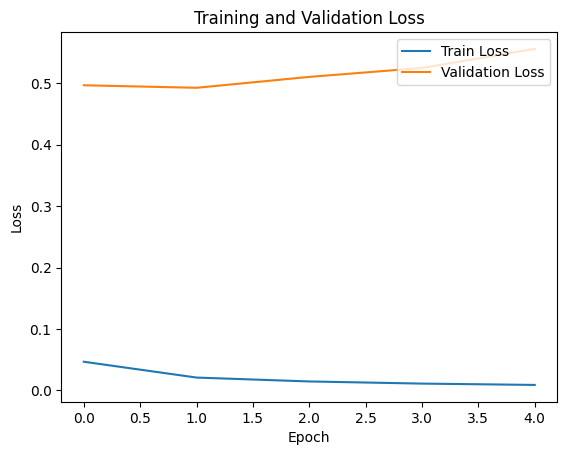

In [25]:
# ✅ Plot Training vs Validation Loss
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.show()
